<center><h1>Supervised Regression<h1></center>

## Predicting Pixel Coordinates in 50×50 Grayscale Images

### Problem Statement
Given a 50×50 grayscale image where exactly one pixel has value 255 and all other pixels are 0, predict the coordinates (x, y) of the bright pixel using Deep Learning.

### Mathematical Formulation
$$f: \mathbb{R}^{1 \times 50 \times 50} \rightarrow \mathbb{R}^2$$

- **Input**: (Batch_Size, 1, 50, 50) grayscale images
- **Output**: (Batch_Size, 2) coordinates [x, y] ∈ [0, 1] (normalized)
- **Loss Function**: Mean Squared Error (MSE)

In [4]:
import cv2
import torch
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from collections import defaultdict
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

In [5]:
def generate_data(num_samples, image_size=50, pixel_value=255):
    """
    Generate synthetic dataset of images with a single bright pixel at random position.
    
    Why this approach?
    ------------------
    - Programmatic generation ensures perfect control over data distribution
    - Each sample has exactly one bright pixel (255) on black background (0)
    - Uniform random distribution ensures no positional bias
    - Reproducible with fixed random seed
    
    Args:
        num_samples (int): Number of images to generate
        image_size (int): Size of the square image (default: 50x50)
        pixel_value (int): Value of the bright pixel (default: 255)
    
    Returns:
        tuple: (images, coordinates)
            - images (np.ndarray): Shape (num_samples, 1, image_size, image_size)
            - coordinates (np.ndarray): Shape (num_samples, 2) with [x, y] positions
    """
    images = np.zeros((num_samples, 1, image_size, image_size), dtype=np.float32)
    coordinates = np.zeros((num_samples, 2), dtype=np.float32)
    
    # Set random seed for reproducibility
    np.random.seed(42)
    
    for i in range(num_samples):
        # Generate random x, y coordinates
        x = np.random.randint(0, image_size)
        y = np.random.randint(0, image_size)
        
        # Place bright pixel at random position
        images[i, 0, y, x] = pixel_value
        
        # Store ground truth coordinates
        coordinates[i] = [x, y]
    
    return images, coordinates


def normalize_data(images, coordinates, image_size=50, pixel_max=255):
    """
    Normalize images and coordinates to [0, 1] range.
    
    Why normalize?
    --------------
    - Neural networks converge faster with normalized inputs
    - Prevents numerical instability during gradient descent
    - Ensures fair weighting across all input dimensions
    - Output normalization matches activation function range (Sigmoid)
    
    Args:
        images (np.ndarray): Raw images with shape (num_samples, 1, image_size, image_size)
        coordinates (np.ndarray): Raw coordinates with shape (num_samples, 2)
        image_size (int): Size of the image (default: 50)
        pixel_max (int): Maximum pixel value (default: 255)
    
    Returns:
        tuple: (images_norm, coords_norm)
            - images_norm (np.ndarray): Normalized images in [0, 1]
            - coords_norm (np.ndarray): Normalized coordinates in [0, 1]
    """
    # Normalize images: [0, 255] -> [0, 1]
    images_norm = images / pixel_max
    
    # Normalize coordinates: [0, image_size-1] -> [0, 1]
    coords_norm = coordinates / image_size
    
    return images_norm, coords_norm


def denormalize_coordinates(normalized_coords, image_size=50):
    """
    Convert normalized coordinates back to original range [0, image_size-1].
    
    Args:
        normalized_coords (np.ndarray): Normalized coordinates in [0, 1]
        image_size (int): Size of the image
    
    Returns:
        np.ndarray: Denormalized coordinates in [0, image_size-1]
    """
    return normalized_coords * image_size


# Generate dataset
print("Generating synthetic dataset...")
total_samples = 10000
X_raw, y_raw = generate_data(total_samples)

print(f"✓ Generated {total_samples} images")
print(f"  Image shape: {X_raw.shape}")
print(f"  Coordinates shape: {y_raw.shape}")
print(f"  Image range: [{X_raw.min()}, {X_raw.max()}]")
print(f"  Coordinate range: x=[{y_raw[:, 0].min()}, {y_raw[:, 0].max()}], y=[{y_raw[:, 1].min()}, {y_raw[:, 1].max()}]")

Generating synthetic dataset...
✓ Generated 10000 images
  Image shape: (10000, 1, 50, 50)
  Coordinates shape: (10000, 2)
  Image range: [0.0, 255.0]
  Coordinate range: x=[0.0, 49.0], y=[0.0, 49.0]


---

## Phase 1: Data Generation

### Rationale Behind Dataset Choices

**Why Synthetic Data Generation?**
1. **Perfect Ground Truth**: We have exact pixel coordinates for every sample
2. **Prevents Memorization**: Random generation ensures the model learns the localization pattern, not fixed positions
3. **Uniform Distribution**: All pixel positions are equally likely, preventing positional bias
4. **Scalability**: Can generate unlimited samples without collection/labeling costs
5. **Controlled Experiments**: Clean signal (single bright pixel) simplifies the learning problem

**Dataset Specifications:**
- **Total Samples**: 10,000 images (8,000 train, 2,000 validation)
- **Image Size**: 50×50 pixels
- **Bright Pixel**: Value 255 at random (x, y) position
- **Background**: All other pixels = 0
- **Distribution**: Uniform random (no spatial bias)

In [6]:
# Normalize the data
print("\nNormalizing data...")
X_normalized, y_normalized = normalize_data(X_raw, y_raw)

print(f"✓ Normalized data")
print(f"  Image range after normalization: [{X_normalized.min()}, {X_normalized.max()}]")
print(f"  Coordinate range after normalization: [{y_normalized.min()}, {y_normalized.max()}]")

# Split data into training (8,000) and validation (2,000)
print("\nSplitting data into train/validation sets...")
X_train, X_val, y_train, y_val = train_test_split(
    X_normalized, 
    y_normalized, 
    test_size=0.2,  # 2,000 validation samples
    random_state=42
)

print(f"✓ Data split complete:")
print(f"  Training set: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"  Validation set: X_val={X_val.shape}, y_val={y_val.shape}")


Normalizing data...
✓ Normalized data
  Image range after normalization: [0.0, 1.0]
  Coordinate range after normalization: [0.0, 0.9800000190734863]

Splitting data into train/validation sets...
✓ Data split complete:
  Training set: X_train=(8000, 1, 50, 50), y_train=(8000, 2)
  Validation set: X_val=(2000, 1, 50, 50), y_val=(2000, 2)


---

## Phase 2: Data Normalization & Splitting

### Normalization Strategy

**Input Normalization**: [0, 255] → [0, 1]
- Accelerates gradient descent convergence
- Prevents numerical instability
- Standard practice for neural networks

**Output Normalization**: [0, 49] → [0, 1]
- Matches Sigmoid activation range
- Ensures fair weighting in loss calculation
- Requires denormalization during inference (multiply by 50)

In [7]:
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define the CNN Model
class PixelCoordinateCNN(nn.Module):
    """
    Convolutional Neural Network for predicting pixel coordinates.
    
    Why CNN?
    --------
    Spatial localization is inherently a visual task. CNNs are ideal because:
    - Convolutional layers detect spatial features (edges, points, patterns)
    - Hierarchical feature learning from low-level to high-level
    - Translation invariance helps generalize across different pixel positions
    - Parameter sharing reduces overfitting on this specific task
    
    Architecture:
    -------------
    - Conv2D(32) → ReLU → MaxPool
    - Conv2D(64) → ReLU → MaxPool
    - Flatten → Dense(128) → ReLU → Dropout
    - Dense(64) → ReLU → Dense(2, Sigmoid)
    
    Output: 2 values in [0, 1] representing normalized (x, y) coordinates
    """
    
    def __init__(self, input_channels=1, dropout_rate=0.3):
        """
        Initialize the CNN model.
        
        Args:
            input_channels (int): Number of input channels (1 for grayscale)
            dropout_rate (float): Dropout probability for regularization
        """
        super(PixelCoordinateCNN, self).__init__()
        
        # Convolutional Block 1: 1 -> 32 filters
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1, bias=True)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Convolutional Block 2: 32 -> 64 filters
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=True)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Calculate flattened size: Input 50x50 -> Conv -> Pool (25x25) -> Conv -> Pool (12x12)
        # So after 2 max pools: 50 // 2 // 2 = 12, with 64 filters
        self.flatten_size = 64 * 12 * 12  # = 9216
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(self.flatten_size, 128, bias=True)
        self.relu3 = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=dropout_rate)
        
        self.fc2 = nn.Linear(128, 64, bias=True)
        self.relu4 = nn.ReLU(inplace=True)
        
        # Output Layer: 2 neurons for (x, y) coordinates
        self.fc_output = nn.Linear(64, 2, bias=True)
        self.sigmoid = nn.Sigmoid()  # Constrains output to [0, 1]
    
    def forward(self, x):
        """
        Forward pass through the network.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 1, 50, 50)
        
        Returns:
            torch.Tensor: Output tensor of shape (batch_size, 2) with values in [0, 1]
        """
        # Conv Block 1
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        # Conv Block 2
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully Connected Layers
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.relu4(x)
        
        # Output Layer with Sigmoid
        x = self.fc_output(x)
        x = self.sigmoid(x)
        
        return x


# Instantiate the model
print("\n" + "="*60)
print("Initializing CNN Model for Pixel Coordinate Prediction")
print("="*60)

model = PixelCoordinateCNN(input_channels=1, dropout_rate=0.3)
model = model.to(device)

# Print model summary
print(f"\nModel Architecture:")
print(f"  Total Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Trainable Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"\n{model}")

# Verify model with a test batch
print(f"\nVerifying model with test batch...")
test_batch = torch.randn(4, 1, 50, 50).to(device)
test_output = model(test_batch)
print(f"  Input shape: {test_batch.shape}")
print(f"  Output shape: {test_output.shape}")
print(f"  Output range: [{test_output.min().item():.4f}, {test_output.max().item():.4f}]")
print(f"✓ Model architecture verified successfully!")

Using device: cpu

Initializing CNN Model for Pixel Coordinate Prediction

Model Architecture:
  Total Parameters: 1,206,978
  Trainable Parameters: 1,206,978

PixelCoordinateCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU(inplace=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (relu3): ReLU(inplace=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu4): ReLU(inplace=True)
  (fc_output): Linear(in_features=64, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)

Verifying model with test batch...
  Input shape: torch.Size([4, 1, 50, 50])
  Output shape: torch.Size([4, 2])
  Out

---

## Phase 3: Model Architecture

### Why CNN for This Problem?

Pixel localization is fundamentally a **spatial task**:
- **Convolutional layers** detect local spatial patterns (edges, points)
- **Hierarchical learning** builds from simple to complex features
- **Translation invariance** generalizes across different pixel positions
- **Parameter efficiency** reduces overfitting vs fully-connected networks

### Architecture Design
Input (1, 50, 50) → Conv32 → Pool → Conv64 → Pool → Dense128 → Dense64 → Output(2)

In [8]:
# Define Loss Function and Optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=1e-5)

print("\n" + "="*60)
print("Training Configuration")
print("="*60)
print(f"Loss Function: {criterion.__class__.__name__}")
print(f"Optimizer: {optimizer.__class__.__name__}")
print(f"  Learning Rate: 0.001")
print(f"  Betas: (0.9, 0.999)")
print(f"  Weight Decay: 1e-5 (L2 regularization)")

# Prepare data for PyTorch
print("\nPreparing DataLoaders...")

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_val_tensor = torch.FloatTensor(X_val).to(device)
y_val_tensor = torch.FloatTensor(y_val).to(device)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"✓ DataLoaders created:")
print(f"  Batch size: {batch_size}")
print(f"  Training batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Device: {device}")


Training Configuration
Loss Function: MSELoss
Optimizer: Adam
  Learning Rate: 0.001
  Betas: (0.9, 0.999)
  Weight Decay: 1e-5 (L2 regularization)

Preparing DataLoaders...
✓ DataLoaders created:
  Batch size: 32
  Training batches: 250
  Validation batches: 63
  Device: cpu


In [9]:
# Training Loop
num_epochs = 50
best_val_loss = float('inf')
train_losses = []
val_losses = []
checkpoint_path = "./best_model.pt"

print("\n" + "="*80)
print("TRAINING")
print("="*80)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0.0
    
    for images, coords in train_loader:
        outputs = model(images)
        loss = criterion(outputs, coords)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
    
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    epoch_val_loss = 0.0
    
    with torch.no_grad():
        for images, coords in val_loader:
            outputs = model(images)
            loss = criterion(outputs, coords)
            epoch_val_loss += loss.item()
    
    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    # Checkpointing
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), checkpoint_path)
        marker = " ✓"
    else:
        marker = ""
    
    # Logging
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}{marker}")

print("="*80)
print(f"Training Complete! Best Val Loss: {best_val_loss:.6f}")
print(f"Model saved to: {checkpoint_path}")
print("="*80)


TRAINING
Epoch [1/50] Train Loss: 0.021040 | Val Loss: 0.001296 ✓
Epoch [10/50] Train Loss: 0.000776 | Val Loss: 0.000638
Epoch [20/50] Train Loss: 0.000476 | Val Loss: 0.000819
Epoch [30/50] Train Loss: 0.000386 | Val Loss: 0.000905
Epoch [40/50] Train Loss: 0.000285 | Val Loss: 0.000933
Epoch [50/50] Train Loss: 0.000246 | Val Loss: 0.000994
Training Complete! Best Val Loss: 0.000565
Model saved to: ./best_model.pt


---

## Phase 4: Training with Checkpointing

### Training Strategy
- **Epochs**: 50
- **Optimizer**: Adam (lr=0.001)
- **Loss**: MSE (Mean Squared Error)
- **Checkpointing**: Save model with lowest validation loss
- **Logging**: Track train/val loss per epoch

In [10]:
# Load best model
model.load_state_dict(torch.load(checkpoint_path))
model.eval()

# Evaluate on validation set
all_predictions = []
all_ground_truth = []

with torch.no_grad():
    for images, coords in val_loader:
        outputs = model(images)
        all_predictions.append(outputs.cpu().numpy())
        all_ground_truth.append(coords.cpu().numpy())

predictions = np.concatenate(all_predictions, axis=0)
ground_truth = np.concatenate(all_ground_truth, axis=0)

# Denormalize coordinates
predictions_denorm = denormalize_coordinates(predictions)
ground_truth_denorm = denormalize_coordinates(ground_truth)

# Calculate MAE in pixels
mae = np.mean(np.abs(predictions_denorm - ground_truth_denorm))
print(f"\nMean Absolute Error: {mae:.4f} pixels")
print(f"On average, prediction is off by {mae:.2f} pixels")


Mean Absolute Error: 0.9084 pixels
On average, prediction is off by 0.91 pixels


---

## Phase 5: Evaluation & Validation

### Evaluation Metrics
- **MAE (Mean Absolute Error)**: Average pixel distance between prediction and ground truth
- **Visual Validation**: Compare predicted (X) vs true (O) coordinates on sample images
- **Sanity Check**: Verify training loss decreased

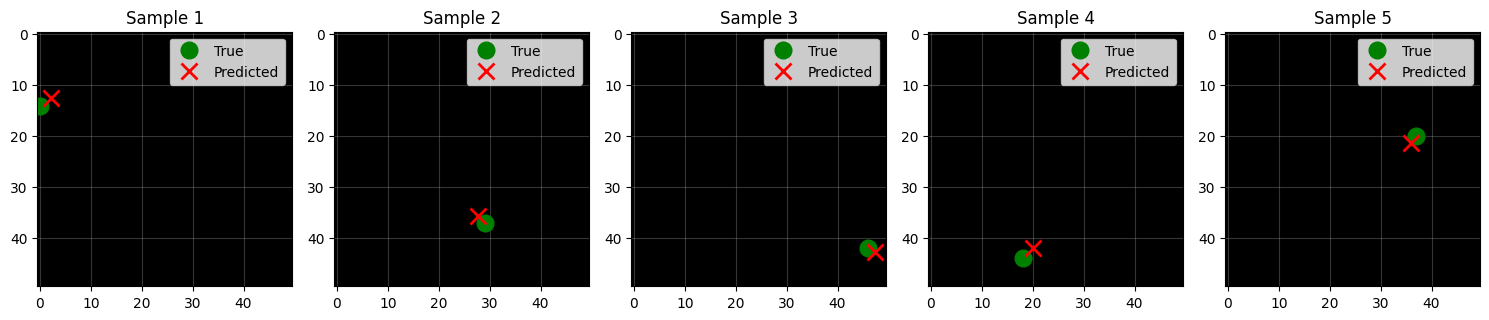

In [11]:
# Visual Validation: Plot 5 random samples
num_samples = 5
random_indices = np.random.choice(len(X_val), num_samples, replace=False)

fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

for i, idx in enumerate(random_indices):
    img = X_val[idx, 0]
    true_coords = denormalize_coordinates(y_val[idx])
    
    # Predict
    with torch.no_grad():
        pred_coords = model(torch.FloatTensor(X_val[idx:idx+1]).to(device))
        pred_coords = denormalize_coordinates(pred_coords.cpu().numpy()[0])
    
    # Plot
    axes[i].imshow(img, cmap='gray')
    axes[i].plot(true_coords[0], true_coords[1], 'go', markersize=12, label='True')
    axes[i].plot(pred_coords[0], pred_coords[1], 'rx', markersize=12, markeredgewidth=2, label='Predicted')
    axes[i].set_title(f"Sample {i+1}")
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

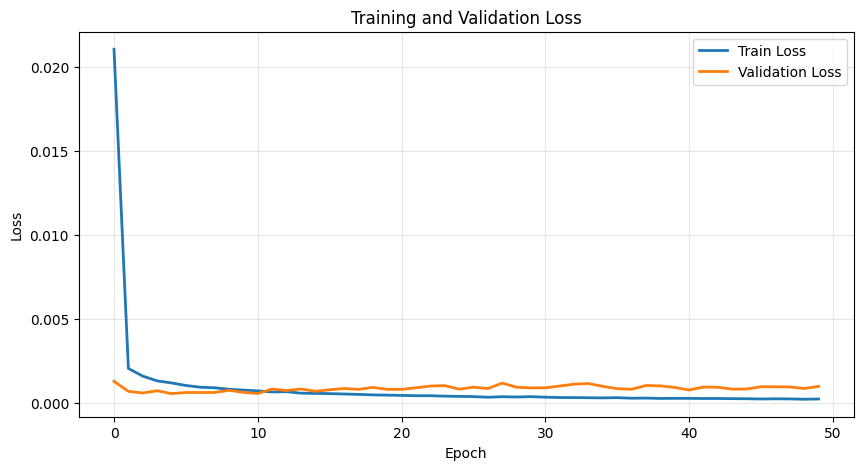


Sanity Check:
Initial Train Loss: 0.021040
Final Train Loss: 0.000246
Loss Decreased: True


In [12]:
# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nSanity Check:")
print(f"Initial Train Loss: {train_losses[0]:.6f}")
print(f"Final Train Loss: {train_losses[-1]:.6f}")
print(f"Loss Decreased: {train_losses[0] > train_losses[-1]}")

---